# Importare le Librerie Necessarie

In [17]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Lettura dati

In [18]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [19]:
data_inizio = '2014-09-17'
data_fine = '2023-12-31'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3388,2023-12-27,38504.562500
3389,2023-12-28,39108.300781
3390,2023-12-29,38515.289062
3391,2023-12-30,38080.046875


# Preparazione dei Periodi di 30 Giorni e train_test_split

In [20]:
# Estrarre periodi di lunghezza 30 giorni dai dati
L = 30
periods = [dati.iloc[i:i + L] for i in range(len(dati) - L + 1)]

# Suddivisione dei periodi in train (70%) e validation/test (30%)
train_periods, validation_periods = train_test_split(periods, test_size=0.3, random_state=42)
validation_periods, test_periods = train_test_split(validation_periods, test_size=0.5, random_state=42)

# Visualizzare il numero di periodi in ciascun insieme
print(f"Train periods: {len(train_periods)}, Validation periods: {len(validation_periods)}, Test periods: {len(test_periods)}")

Train periods: 2354, Validation periods: 505, Test periods: 505


# Definizione dell'Ambiente Personalizzato TradingEnv per Train e Validation

In [21]:
class TradingEnv(gym.Env):
    def __init__(self, periods, initial_cash=1000, initial_btc=0):
        super(TradingEnv, self).__init__()
        
        self.periods = periods
        self.initial_cash = initial_cash
        self.initial_btc = initial_btc
        self.current_step = 0
        self.current_period = None
        self.initial_price = None

        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(30,), dtype=np.float32  # Assicuriamo che la dimensione sia sempre (30,)
        )
    
    def reset(self):
        self.current_period = random.choice(self.periods).reset_index(drop=True)
        self.current_step = 0
        self.cash = self.initial_cash
        self.btc = self.initial_btc
        self.initial_price = self.current_period['Price'].iloc[self.current_step]
        
        # Prima osservazione, riempita con zeri se necessario
        obs = self.current_period['Price'].values[:self.current_step + 1]
        return np.pad(obs, (0, 30 - len(obs)), mode='constant')

    def step(self, action):
        percentage = action[0]
        price = self.current_period['Price'].iloc[self.current_step]

        if percentage < 0:  # Vendita
            btc_to_sell = -percentage * self.btc
            self.btc -= btc_to_sell
            self.cash += btc_to_sell * price
        elif percentage > 0:  # Acquisto
            cash_to_spend = percentage * self.cash
            btc_bought = cash_to_spend / price
            self.btc += btc_bought
            self.cash -= cash_to_spend

        self.current_step += 1
        done = self.current_step >= len(self.current_period) - 1

        total_value = self.cash + self.btc * price
        initial_total_value = self.initial_cash + self.initial_btc * self.initial_price
        reward = total_value - initial_total_value

        # Osservazione, riempita con zeri se necessario
        obs = self.current_period['Price'].values[:self.current_step + 1]
        return np.pad(obs, (0, 30 - len(obs)), mode='constant'), reward, done, {}

    def render(self):
        total_value = self.cash + self.btc * self.current_period['Price'].iloc[self.current_step]
        print(f'Step: {self.current_step}, Cash: {self.cash}, BTC: {self.btc}, Total Value: {total_value}')

# Creare gli Ambienti di Addestramento e di Validazione

In [22]:
train_env = TradingEnv(periods=train_periods)
validation_env = TradingEnv(periods=validation_periods)

# Addestrare l'Agente con Monitoraggio su validation

In [23]:
# Addestramento dell'agente su train_env
model = PPO("MlpPolicy", train_env, verbose=1)

# Training con valutazione periodica su validation_env
n_train_steps = 50000
n_eval_episodes = 5
validation_rewards = []

# Training loop con valutazione periodica
for step in range(0, n_train_steps, 10000):  # Ogni 10,000 timesteps valutiamo l'agente
    model.learn(total_timesteps=10000, reset_num_timesteps=False)
    
    # Valutazione su validation_env
    rewards = []
    for _ in range(n_eval_episodes):
        obs = validation_env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, _ = validation_env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    
    # Memorizza i reward di validazione
    avg_validation_reward = np.mean(rewards)
    validation_rewards.append(avg_validation_reward)
    print(f"Average validation reward at step {step + 10000}: {avg_validation_reward}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Kaggle\Bitcoin Historical Dataset\trading_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29       |
|    ep_rew_mean     | 481      |
| time/              |          |
|    fps             | 511      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 29             |
|    ep_rew_mean          | 945            |
| time/                   |                |
|    fps                  | 380            |
|    iterations           | 2              |
|    time_elapsed         | 10             |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | 0.0026161533   |
|    clip_fraction        | 0.012          |
|    clip_range           | 0.2            |
|    entropy_loss         | -1.42          |
|    explained_variance   | -2

# Test Finale su Periodi di Test

In [24]:
# Test finale su test_periods
test_env = TradingEnv(periods=test_periods)
obs = test_env.reset()
done = False
total_test_reward = 0

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    total_test_reward += reward
    test_env.render()

print(f"Total reward on test data: {total_test_reward}")

Step: 1, Cash: 882.987060546875, BTC: 0.004772029617871304, Total Value: 997.1422388933734
Step: 2, Cash: 0.0, BTC: 0.04168354310468862, Total Value: 998.9278739537546
Step: 3, Cash: 234.6402363868084, BTC: 0.03189240936766303, Total Value: 1002.6491326022575
Step: 4, Cash: 393.63972067119477, BTC: 0.02528978188895421, Total Value: 999.882618161206
Step: 5, Cash: 79.83552228821043, BTC: 0.03838031006800731, Total Value: 1000.9555427276188
Step: 6, Cash: 0.0, BTC: 0.041706816963820004, Total Value: 1014.5650798967521
Step: 7, Cash: 0.0, BTC: 0.041706816963820004, Total Value: 1010.4467760974555
Step: 8, Cash: 0.0, BTC: 0.041706816963820004, Total Value: 1006.3610557489119
Step: 9, Cash: 0.0, BTC: 0.041706816963820004, Total Value: 1004.8463325820326
Step: 10, Cash: 0.0, BTC: 0.041706816963820004, Total Value: 1007.7986375961336
Step: 11, Cash: 0.0, BTC: 0.041706816963820004, Total Value: 1005.7602169170269
Step: 12, Cash: 0.0, BTC: 0.041706816963820004, Total Value: 1063.9353615604202
S

# Funzione per l’Uso Giornaliero

In [25]:
def get_trading_action(model, new_data):
    new_env = TradingEnv(periods=[new_data])
    obs = new_env.reset()
    action, _states = model.predict(obs)
    return action[0]

# Esempio di utilizzo su nuovi dati
new_data = dati.iloc[-30:]

action_today = get_trading_action(model, new_data)
print("Azione consigliata per oggi:", action_today)

Azione consigliata per oggi: -0.8026737


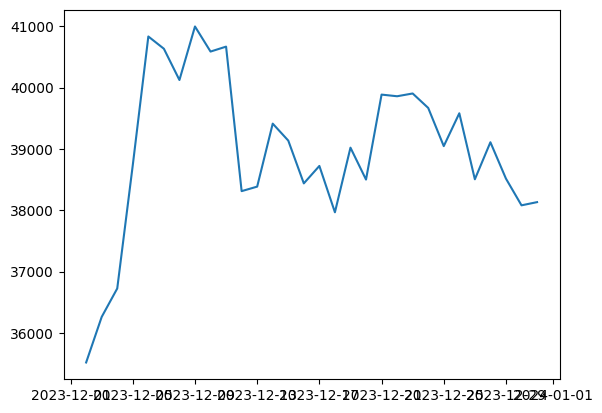

In [26]:
plt.plot(new_data['Timestamp'], new_data['Price'])